In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from pyvbmc import VBMC
import corner
from psiam_tied_dv_map_utils import rho_A_t_fn, up_RTs_fit_fn, down_RTs_fit_fn, up_RTs_fit_single_t_fn, psiam_tied_data_gen_wrapper

In [2]:
import pickle
with open('../fitting_aborts/post_led_censor_test_vbmc.pkl', 'rb') as f:
    vp = pickle.load(f)

In [3]:
vp_sample = vp.sample(int(1e6))[0]

In [4]:
V_A = np.mean(vp_sample[:,0])
theta_A = np.mean(vp_sample[:,1])
t_motor = 0.04

# t_A_aff = np.mean(vp_sample[:,2]) - t_motor
t_A_aff = 0.05

# simulator

In [5]:
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


In [6]:
N_sim = int(50e3)
N_print = int(10e3)
dt = 1e-3; dB = np.sqrt(dt);

rate_lambda = 0.076
theta_E = 50
T_0 = 0.19 * (1e-3)

t_E_aff = 0.03
Z_E = 0
L = 1

t_stim_0 = 0.2; t_stim_tau = 0.4

sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper)(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, t_motor, L, \
                                t_stim_0, t_stim_tau, iter_num, N_print, dt) for iter_num in range(N_sim))

In iter_num: 0, ABL: 20, ILD: -8.0, t_stim: 0.30016464290745826
In iter_num: 10000, ABL: 20, ILD: 8.0, t_stim: 0.4047323606906159
In iter_num: 20000, ABL: 40, ILD: 8.0, t_stim: 0.20422828695850506
In iter_num: 30000, ABL: 40, ILD: -8.0, t_stim: 0.30080096810809015
In iter_num: 40000, ABL: 40, ILD: -16.0, t_stim: 0.8773519445198714


# VBMC

## loglike fn

In [7]:
def compute_loglike(row, rate_lambda, T_0, theta_E, t_E_aff, Z_E, L):
    
    ILD = row['ILD']
    ABL = row['ABL']
    choice = row['choice']

    rt = row['rt']
    t_stim = row['t_stim']
    
    K_max = 10

    if choice == 1:
        likelihood = up_RTs_fit_fn([rt], V_A, theta_A, ABL, ILD, rate_lambda, T_0, \
                                    theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max)[0]
    elif choice == -1:
        likelihood = down_RTs_fit_fn([rt], V_A, theta_A, ABL, ILD, rate_lambda, T_0,\
                                        theta_E, Z_E, t_stim, t_A_aff, t_E_aff, t_motor, L, K_max)[0]


    if likelihood <= 0:
        likelihood = 1e-50

    
    return np.log(likelihood)    


def psiam_tied_loglike_fn(params):
    rate_lambda, T_0, theta_E, t_E_aff, Z_E, L = params


    all_loglike = Parallel(n_jobs=-1)(delayed(compute_loglike)(row, rate_lambda, T_0, theta_E, t_E_aff, Z_E, L)\
                                       for row in sim_results if row['rt'] > row['t_stim'])

    loglike = np.sum(all_loglike)
    return loglike

## Bounds

In [8]:
rate_lambda_bounds = [0.01, 0.2]
T_0_bounds = [0.1*(1e-3), 0.8*(1e-3)]
theta_E_bounds = [40, 60]

t_E_aff_bounds = [0.01, 0.1]
Z_E_bounds = [-10, 10]
L_bounds = [0.1, 1.99]

# ---
rate_lambda_plausible_bounds =  [0.05, 0.09]
T_0_plausible_bounds = [0.15*(1e-3), 0.5*(1e-3)]
theta_E_plausible_bounds = [48, 52]

t_E_aff_plausible_bounds = [0.02, 0.04]
Z_E_plausible_bounds = [-5, 5]
L_plausible_bounds = [0.5, 1.5]

## prior

In [9]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def psiam_tied_prior_fn(params):
    rate_lambda, T_0, theta_E, t_E_aff, Z_E, L = params

    rate_lambda_logpdf = trapezoidal_logpdf(rate_lambda, rate_lambda_bounds[0], rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1], rate_lambda_bounds[1])
    theta_E_logpdf = trapezoidal_logpdf(theta_E, theta_E_bounds[0], theta_E_plausible_bounds[0], theta_E_plausible_bounds[1], theta_E_bounds[1])
    T_0_logpdf = trapezoidal_logpdf(T_0, T_0_bounds[0], T_0_plausible_bounds[0], T_0_plausible_bounds[1], T_0_bounds[1])
    
    t_E_aff_logpdf = trapezoidal_logpdf(t_E_aff, t_E_aff_bounds[0], t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1], t_E_aff_bounds[1])
    Z_E_logpdf = trapezoidal_logpdf(Z_E, Z_E_bounds[0], Z_E_plausible_bounds[0], Z_E_plausible_bounds[1], Z_E_bounds[1])
    L_logpdf = trapezoidal_logpdf(L, L_bounds[0], L_plausible_bounds[0], L_plausible_bounds[1], L_bounds[1])

    return rate_lambda_logpdf + T_0_logpdf + theta_E_logpdf + t_E_aff_logpdf + Z_E_logpdf + L_logpdf


## prior + loglike

In [10]:
def psiam_tied_joint_fn(params):
    priors = psiam_tied_prior_fn(params) 
    loglike = psiam_tied_loglike_fn(params)

    joint = priors + loglike
    return joint

## run vbmc

In [11]:
lb = np.array([ rate_lambda_bounds[0], T_0_bounds[0], theta_E_bounds[0], \
               t_E_aff_bounds[0], Z_E_bounds[0], L_bounds[0]])
ub = np.array([ rate_lambda_bounds[1], T_0_bounds[1], theta_E_bounds[1], \
                t_E_aff_bounds[1], Z_E_bounds[1], L_bounds[1]])

plb = np.array([ rate_lambda_plausible_bounds[0], T_0_plausible_bounds[0], theta_E_plausible_bounds[0], \
                t_E_aff_plausible_bounds[0], Z_E_plausible_bounds[0], L_plausible_bounds[0]])

pub = np.array([rate_lambda_plausible_bounds[1], T_0_plausible_bounds[1], theta_E_plausible_bounds[1], \
                t_E_aff_plausible_bounds[1], Z_E_plausible_bounds[1], L_plausible_bounds[1]])


np.random.seed(42)
rate_lambda_0 = np.random.uniform(rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1])
T_0_0 = np.random.uniform(T_0_plausible_bounds[0], T_0_plausible_bounds[1])
theta_E_0 = np.random.uniform(theta_E_plausible_bounds[0], theta_E_plausible_bounds[1])

t_E_aff_0 = np.random.uniform(t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1])
Z_E_0 = np.random.uniform(Z_E_plausible_bounds[0], Z_E_plausible_bounds[1])
L_0 = np.random.uniform(L_plausible_bounds[0], L_plausible_bounds[1])

x_0 = np.array([rate_lambda_0, T_0_0, theta_E_0, t_E_aff_0, Z_E_0, L_0])

vbmc = VBMC(psiam_tied_joint_fn, x_0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 6).
Reshaping upper bounds to (1, 6).
Reshaping plausible lower bounds to (1, 6).
Reshaping plausible upper bounds to (1, 6).
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: 42576.297 +/-0.008.


## corner plots

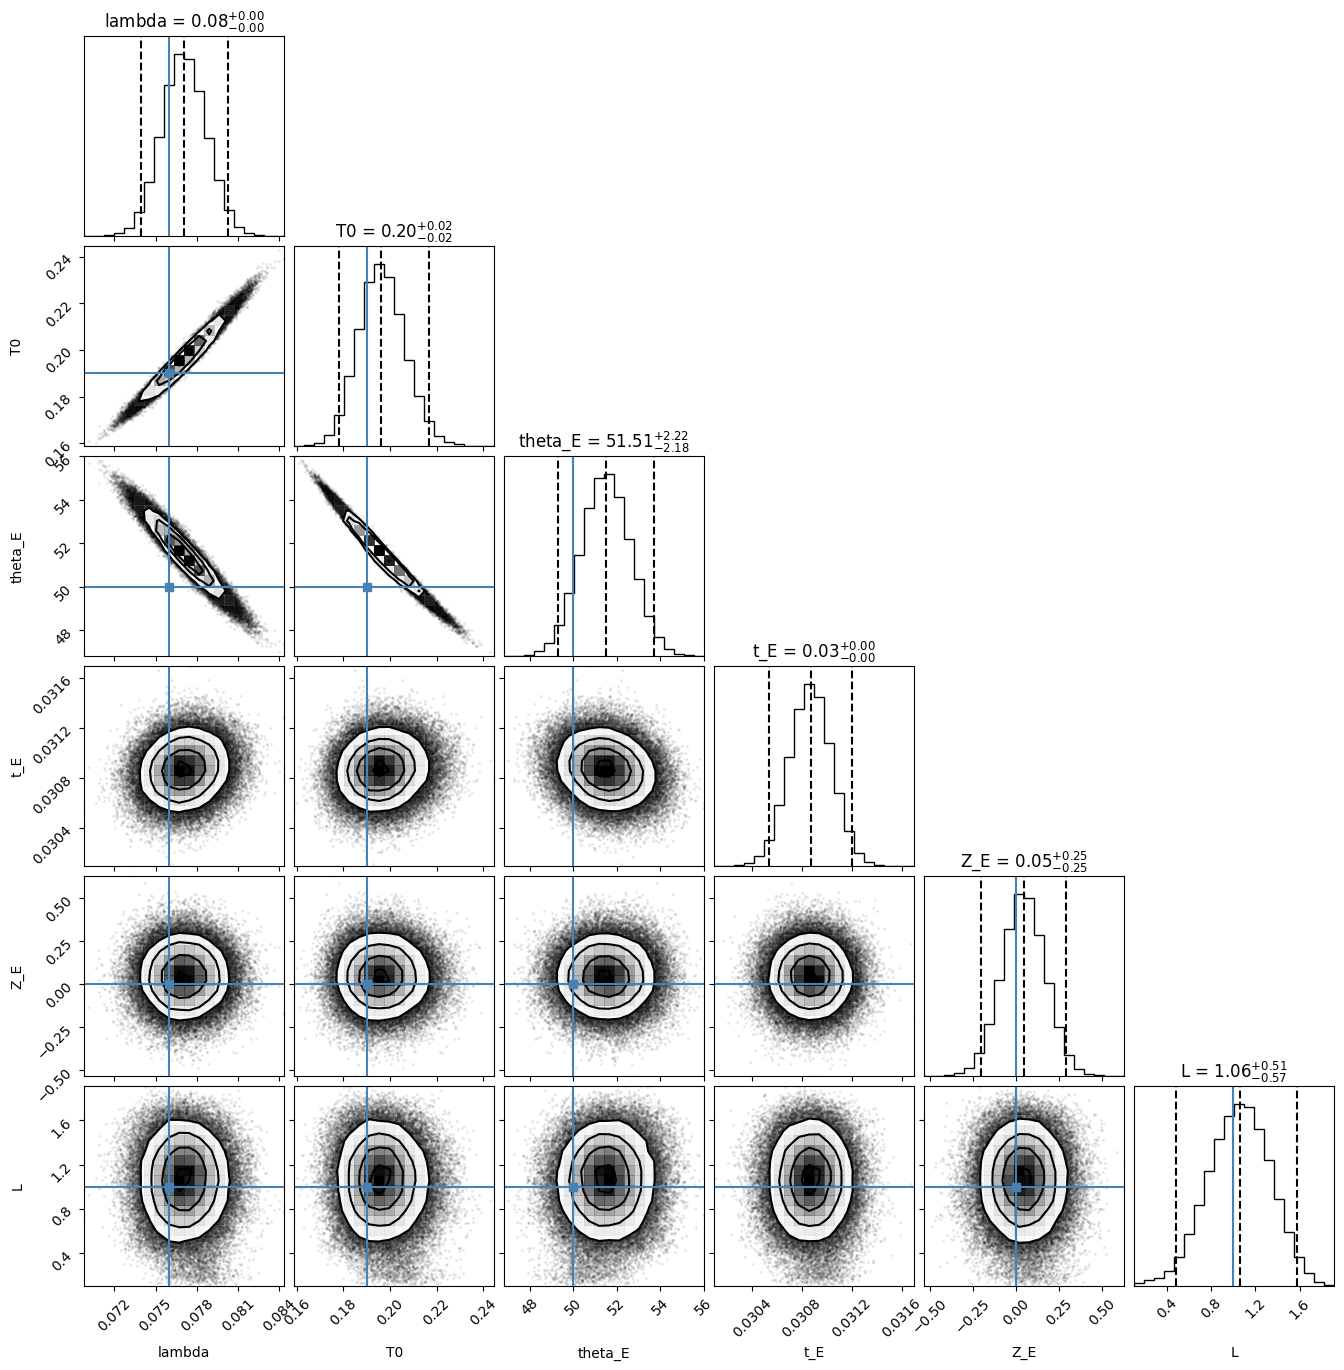

In [12]:
vp_samples = vp.sample(int(1e5))[0]
vp_samples[:,1] *= 1000

param_labels = ['lambda', 'T0', 'theta_E', 't_E', 'Z_E', 'L']

percentiles = np.percentile(vp_samples, [0, 100], axis=0)
# _ranges = [(lb[i], ub[i]) for i in np.arange(vp_samples.shape[1])]
_ranges = [(percentiles[0, i], percentiles[1, i]) for i in np.arange(vp_samples.shape[1])]

true_params = [rate_lambda, T_0*1000, theta_E, t_E_aff, Z_E, L]

# Now create the corner plot using these ranges
corner.corner(
    vp_samples,
    labels=param_labels,
    show_titles=True,
    quantiles=[0.025, 0.5, 0.975],
    range=_ranges,
    truths=true_params,
);

# see only aborts fit?

In [13]:
sim_results_abort  = [res for res in sim_results if res['rt'] < res['t_stim']]

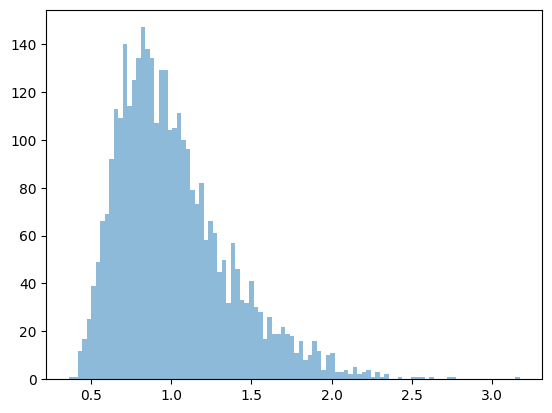

In [14]:
plt.hist([res['rt'] for res in sim_results_abort], bins=100, alpha=0.5, label='Simulated RTs');

In [15]:
# fit these aborts
V_A = np.mean(vp_sample[:,0])
theta_A = np.mean(vp_sample[:,1])
t_motor = 0.04
t_A_aff = 0.05

In [18]:
V_A, theta_A

(1.5963403919613817, 2.5315363529172843)

In [17]:
def pro_loglike_fn(params):
    v, theta, t_a, t_m = params
    return np.sum(np.log([rho_A_t_fn(res['rt'] - t_a - t_m, v, theta) for res in  sim_results_abort]))

In [19]:
v_bounds = [0.1, 5]
theta_bounds = [0.1, 5]
t_a_bounds = [0.01, 0.1]
t_m_bounds = [0.01, 0.1]

v_plausible_bounds = [0.5, 2]
theta_plausible_bounds = [0.5, 3]
t_a_plausible_bounds = [0.02, 0.06]
t_m_plausible_bounds = [0.02, 0.06]

In [20]:
def pro_prior_fn(params):
    v, theta, t_a, t_m = params

    v_pdf = trapezoidal_logpdf(v, v_bounds[0], v_plausible_bounds[0], v_plausible_bounds[1], v_bounds[1])
    theta_pdf = trapezoidal_logpdf(theta, theta_bounds[0], theta_plausible_bounds[0], theta_plausible_bounds[1], theta_bounds[1])
    t_a_pdf = trapezoidal_logpdf(t_a, t_a_bounds[0], t_a_plausible_bounds[0], t_a_plausible_bounds[1], t_a_bounds[1])
    t_m_pdf = trapezoidal_logpdf(t_m, t_m_bounds[0], t_m_plausible_bounds[0], t_m_plausible_bounds[1], t_m_bounds[1])

    return v_pdf + theta_pdf + t_a_pdf + t_m_pdf


In [21]:
def pro_joint_fn(params):
    priors = pro_prior_fn(params)
    loglike = pro_loglike_fn(params)

    joint = priors + loglike
    return joint

In [23]:
lb = [v_bounds[0], theta_bounds[0], t_a_bounds[0], t_m_bounds[0]]
ub = [v_bounds[1], theta_bounds[1], t_a_bounds[1], t_m_bounds[1]]
plb = [v_plausible_bounds[0], theta_plausible_bounds[0], t_a_plausible_bounds[0], t_m_plausible_bounds[0]]
pub = [v_plausible_bounds[1], theta_plausible_bounds[1], t_a_plausible_bounds[1], t_m_plausible_bounds[1] ]

np.random.seed(42)
v_0 = np.random.uniform(v_plausible_bounds[0], v_plausible_bounds[1])
theta_0 = np.random.uniform(theta_plausible_bounds[0], theta_plausible_bounds[1])
t_a_0 = np.random.uniform(t_a_plausible_bounds[0], t_a_plausible_bounds[1])
t_m_0 = np.random.uniform(t_m_plausible_bounds[0], t_m_plausible_bounds[1])

x_0 = np.array([v_0, theta_0, t_a_0, t_m_0])

vbmc = VBMC(pro_joint_fn, x_0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 4).
Reshaping upper bounds to (1, 4).
Reshaping plausible lower bounds to (1, 4).
Reshaping plausible upper bounds to (1, 4).


/home/rlab/raghavendra/code/ddm_data/.venv/lib/python3.12/site-packages/cma/evolution_strategy.py:3379: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/home/rlab/raghavendra/code/ddm_data/.venv/lib/python3.12/site-packages/cma/evolution_strategy.py:3379: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -938.309 +/-0.009.


In [24]:
pro_samp = vp.sample(int(1e5))[0]

In [26]:
fit_v = np.mean(pro_samp[:,0])
fit_theta = np.mean(pro_samp[:,1])
fit_t_a = np.mean(pro_samp[:,2])
fit_t_m = np.mean(pro_samp[:,3])


In [27]:
print(fit_v, fit_theta, fit_t_a, fit_t_m)
print(V_A, theta_A, t_A_aff, t_motor)

2.651130048756137 2.330692107370159 0.07025108915885271 0.06900888954800236
1.5963403919613817 2.5315363529172843 0.05 0.04


In [28]:
dt = 1e-3
dB = np.sqrt(dt)
def pro_sim(v,theta,t_a, t_m):
    dv = 0
    t = t_a
    while True:
        dv += v*dt + np.random.normal(0, dB)
        t += dt

        if dv >= theta:
            return t
    

In [ ]:
# TODO : 
# 1. check if likelihood fitting of aborts is done rightly or not? 
# 2. check pro fit params
# 3. compare